In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr

from theano import tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(286)

WARN: Could not locate executable armflang
Running on PyMC3 v3.11.5


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

'''from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy import sparse
from spreg import ML_Lag, ML_Error
from libpysal.weights.util import get_points_array_from_shapefile
from libpysal.weights import Queen
import geopandas as gpd
from libpysal import weights
import matplotlib.pyplot as plt
import contextily as ctx
import libpysal as lps
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import pysal.lib
import pysal.model.spreg
from pysal.model.spreg import GM_Error_Het
from pysal.lib import weights


import spreg  # for spatial regression
from scipy import stats
import statsmodels.api as sm '''

'from sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom scipy.sparse import csr_matrix\nfrom scipy import sparse\nfrom spreg import ML_Lag, ML_Error\nfrom libpysal.weights.util import get_points_array_from_shapefile\nfrom libpysal.weights import Queen\nimport geopandas as gpd\nfrom libpysal import weights\nimport matplotlib.pyplot as plt\nimport contextily as ctx\nimport libpysal as lps\nimport statsmodels.api as sm\nfrom sklearn.metrics import mean_squared_error, r2_score\nimport pysal.lib\nimport pysal.model.spreg\nfrom pysal.model.spreg import GM_Error_Het\nfrom pysal.lib import weights\n\n\nimport spreg  # for spatial regression\nfrom scipy import stats\nimport statsmodels.api as sm '

In [3]:
mobile_path = '/home/manifold/Desktop/DAP/cdr_rs_mapping/mobile_features.csv'
satellite_path = '/home/manifold/Desktop/DAP/satellite_features.csv'
pca_path = '/home/manifold/Desktop/DAP/cdr_rs_mapping/pca_census.csv'

#Reading Ground truth DATA and filtering zero population gnds (Grama niladhari divisions are referred to as gnd, which are the smallest diviions in Sri Lanka)
data_pca = pd.read_csv(pca_path)
missing_gnd_ids = data_pca.loc[data_pca['PC1'].isnull(), 'gnd_id']
count = missing_gnd_ids.count()
print('No of gnds with zero population:',count)

# Read the datasets and merge into a single pandas dataframe
data_raw = pd.read_csv(mobile_path).merge(pd.read_csv(satellite_path), on='gnd_id').merge(pd.read_csv(pca_path), on='gnd_id').rename(columns={"PC1": "pc_1"}).set_index('gnd_id')

#Removing the zero population gnds from the dataframe
data_raw = data_raw[~data_raw.index.isin(missing_gnd_ids)]

# Log transform skewed variables
data_unskewed = data_raw[[

    #Call detail records
    "call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",

    #Remote Sensing data
    "travel_time_major_cities",
    "population_count_worldpop",
    "population_count_ciesin",
    "population_density",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk",
    "distance_roadways_primary",
    "distance_roadways_secondary",
    "distance_roadways_tertiary",
    "distance_waterways",
    "urban_rural_fb",
    "urban_rural_ciesin",
    "global_human_settlement",
    "protected_areas",
    "land_cover_woodland",
    "land_cover_grassland",
    "land_cover_cropland",
    "land_cover_wetland",
    "land_cover_bareland",
    "land_cover_urban",
    "land_cover_water",
    "pregnancies",
    "births",
    "precipitation",
    "temperature",

    #principle componanet analysis
    "pc_1"
]].copy()

# Log transform skewed variables
data_unskewed.loc[:, "radius_of_gyration_log"] = np.log(data_unskewed["radius_of_gyration"])
data_unskewed.loc[:, "travel_time_major_cities_log"] = np.log(data_unskewed["travel_time_major_cities"] + 1)
data_unskewed.loc[:, "population_count_worldpop_log"] = np.log(data_unskewed["population_count_worldpop"] + 1)
data_unskewed.loc[:, "population_count_ciesin_log"] = np.log(data_unskewed["population_count_ciesin"] + 1)
data_unskewed.loc[:, "population_density_log"] = np.log(data_unskewed["population_density"])
data_unskewed.loc[:, "elevation_log"] = np.log(data_unskewed["elevation"] + 1)
data_unskewed.loc[:, "distance_roadways_trunk_log"] = np.log(data_unskewed["distance_roadways_trunk"] + 1)
data_unskewed.loc[:, "distance_roadways_primary_log"] = np.log(data_unskewed["distance_roadways_primary"] + 1)
data_unskewed.loc[:, "distance_roadways_secondary_log"] = np.log(data_unskewed["distance_roadways_secondary"] + 1)
data_unskewed.loc[:, "distance_roadways_tertiary_log"] = np.log(data_unskewed["distance_roadways_tertiary"] + 1)
data_unskewed.loc[:, "distance_waterways_log"] = np.log(data_unskewed["distance_waterways"] + 1)
data_unskewed.loc[:, "urban_rural_fb_log"] = np.log(data_unskewed["urban_rural_fb"] + 1)
data_unskewed.loc[:, "global_human_settlement_log"] = np.log(data_unskewed["global_human_settlement"] + 1)
data_unskewed.loc[:, "protected_areas_log"] = np.log(data_unskewed["protected_areas"] + 1)
data_unskewed.loc[:, "land_cover_grassland_log"] = np.log(data_unskewed["land_cover_grassland"] + 1)
data_unskewed.loc[:, "land_cover_wetland_log"] = np.log(data_unskewed["land_cover_wetland"] + 1)
data_unskewed.loc[:, "land_cover_bareland_log"] = np.log(data_unskewed["land_cover_bareland"] + 1)
data_unskewed.loc[:, "land_cover_water_log"] = np.log(data_unskewed["land_cover_water"] + 1)
data_unskewed.loc[:, "pregnancies_log"] = np.log(data_unskewed["pregnancies"])
data_unskewed.loc[:, "births_log"] = np.log(data_unskewed["births"])


#Optional step, consider rs_only variable when conducting the study only with remote sensing data
rs_only = data_unskewed[[
    "travel_time_major_cities_log",
    "population_count_worldpop_log",
    "population_count_ciesin_log",
    "population_density_log",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation_log",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk_log",
    "distance_roadways_primary_log",
    "distance_roadways_secondary_log",
    "distance_roadways_tertiary_log",
    "distance_waterways_log",
    "urban_rural_fb_log",
    "urban_rural_ciesin",
    "global_human_settlement_log",
    "protected_areas_log",
    "land_cover_woodland",
    "land_cover_grassland_log",
    "land_cover_cropland",
    "land_cover_wetland_log",
    "land_cover_bareland_log",
    "land_cover_urban",
    "land_cover_water_log",
    "pregnancies_log",
    "births_log",
    "precipitation",
    "temperature",

    #principle componanet analysis
    "pc_1"
]].copy()

#Optional step, consider cdr_only variable when conducting the study only with call detail records

cdr_only = data_unskewed[[
"call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",
    #principle componanet analysis
    "pc_1" 
]].copy()

#data_unskewed = cdr_only.copy()


No of gnds with zero population: 37


In [4]:
data_unskewed = data_unskewed.drop(columns=["radius_of_gyration", "travel_time_major_cities", "population_count_worldpop", "population_count_ciesin", "population_density", "elevation", "distance_roadways_trunk", "distance_roadways_primary", "distance_roadways_secondary", "distance_roadways_tertiary", "distance_waterways", "urban_rural_fb", "global_human_settlement", "protected_areas", "land_cover_grassland", "land_cover_wetland", "land_cover_bareland", "land_cover_water", "pregnancies", "births"])

In [5]:
#fill missing values with their mean
data_unskewed.fillna(data_unskewed.mean(), inplace=True)
data_unskewed.isna().sum()

call_count                         0
avg_call_duration                  0
nighttime_call_count               0
avg_nighttime_call_duration        0
incoming_call_count                0
avg_incoming_call_duration         0
unique_tower_count                 0
spatial_entropy                    0
avg_call_count_per_contact         0
avg_call_duration_per_contact      0
contact_count                      0
social_entropy                     0
aridity_index                      0
evapotranspiration                 0
nighttime_lights                   0
vegetation                         0
distance_roadways_motorway         0
urban_rural_ciesin                 0
land_cover_woodland                0
land_cover_cropland                0
land_cover_urban                   0
precipitation                      0
temperature                        0
pc_1                               0
radius_of_gyration_log             0
travel_time_major_cities_log       0
population_count_worldpop_log      0
p

In [6]:
az.style.use("arviz-darkgrid")

data_unskewed.columns = data_unskewed.columns.map(str.strip)

data_b = data_unskewed.copy()


# Styling using arviz-darkgrid
az.style.use("arviz-darkgrid")

In [7]:
data_b.tail()

,call_count,avg_call_duration,nighttime_call_count,avg_nighttime_call_duration,incoming_call_count,avg_incoming_call_duration,unique_tower_count,spatial_entropy,avg_call_count_per_contact,avg_call_duration_per_contact,...,distance_waterways_log,urban_rural_fb_log,global_human_settlement_log,protected_areas_log,land_cover_grassland_log,land_cover_wetland_log,land_cover_bareland_log,land_cover_water_log,pregnancies_log,births_log
gnd_id,,,,,,,,,,,,,,,,,,,,,
9233110,1828.586150,103.870109,110.604331,138.698172,844.064536,103.740225,32.790384,0.289792,12.745032,1455.549096,...,7.641974,0.021436,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.588116,3.202639
9233115,1849.453218,100.562759,110.813929,132.735152,862.682858,100.494407,31.940914,0.285619,12.830961,1398.670296,...,7.274439,0.026455,0.018623,0.000000,0.000000,0.0,0.0,0.0,4.115742,3.730266
9233120,1851.605078,100.221698,110.835543,132.120232,864.602821,100.159691,31.853315,0.285189,12.839822,1392.804827,...,7.368218,0.048076,0.118310,0.000000,0.030772,0.0,0.0,0.0,3.831375,3.445899
9233125,1769.532957,100.552199,108.178189,131.662986,823.954106,100.125781,31.033007,0.311246,12.298642,1340.458170,...,5.666200,0.013150,0.000000,0.485248,0.029559,0.0,0.0,0.0,4.749389,4.363913
9233130,1363.262939,103.702603,90.880505,134.389663,619.449213,101.766199,30.143450,0.406707,9.777221,1101.706249,...,0.000000,0.009994,0.011719,0.569550,0.014389,0.0,0.0,0.0,5.096190,4.710714


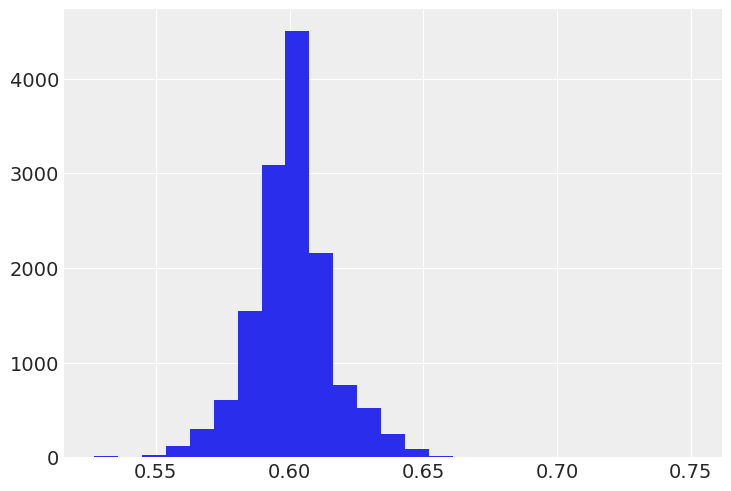

In [8]:
data_b.social_entropy.hist(bins=25);

# Conventional approaches

The two conventional alternatives to modeling index represent the two extremes of the bias-variance tradeoff:

* Complete pooling *:

Treat all gnds the same, and estimate a single index level.

* No pooling*:

Model index in each gnd independently.



In [9]:
call_c = data_b.call_count.values

In [10]:
'''# Ensure that data_b.index contains unique values that match the levels you want to use
data_b.index = data_b.index.astype(str)  # Convert index to string for matching with Level

coords = {
    "Level": data_b.index.tolist(),  # Assuming data_b.index contains unique smallest regions
    "obs_id": np.arange(data_b.shape[0])
}

with pm.Model(coords=coords) as pooled_model:
    # Define the intercept parameter 'a' varying by Level
    intercept = pm.Normal("intercept", mu=0, sigma=10, dims="Level")
    coefficients = pm.Normal("coefficients", mu=0, sigma=10, dims=("Level", "obs_id"))  # Transpose the dimensions

    # Linear model
    # Transpose the coefficients and perform element-wise multiplication
    linear_combination = (data_b[["call_count", "social_entropy", "unique_tower_count", "incoming_call_count"]].values.T * coefficients).sum(axis=0)

    # Calculate theta by adding intercept to the linear combination
    theta = intercept[data_b.index] + linear_combination

    # Define the standard deviation parameter 'sigma'
    sigma = pm.Exponential("sigma", 1.0)

    # Define the likelihood of observing the data 'data_b['pc_1']' given theta and sigma
    y = pm.Normal("y", theta, sigma=sigma, observed=data_b['pc_1'], dims="obs_id")

# Visualize the model
pm.model_to_graphviz(pooled_model)
'''


'# Ensure that data_b.index contains unique values that match the levels you want to use\ndata_b.index = data_b.index.astype(str)  # Convert index to string for matching with Level\n\ncoords = {\n    "Level": data_b.index.tolist(),  # Assuming data_b.index contains unique smallest regions\n    "obs_id": np.arange(data_b.shape[0])\n}\n\nwith pm.Model(coords=coords) as pooled_model:\n    # Define the intercept parameter \'a\' varying by Level\n    intercept = pm.Normal("intercept", mu=0, sigma=10, dims="Level")\n    coefficients = pm.Normal("coefficients", mu=0, sigma=10, dims=("Level", "obs_id"))  # Transpose the dimensions\n\n    # Linear model\n    # Transpose the coefficients and perform element-wise multiplication\n    linear_combination = (data_b[["call_count", "social_entropy", "unique_tower_count", "incoming_call_count"]].values.T * coefficients).sum(axis=0)\n\n    # Calculate theta by adding intercept to the linear combination\n    theta = intercept[data_b.index] + linear_combin

In [11]:
'''
with pm.Model() as model_besag_1:
    # Define the prior distributions for the parameters
    a = pm.Normal("a", mu=0, sigma=10)  # Prior for intercept
    b_unique_tower_count = pm.Normal("b_unique_tower_count", mu=0, sigma=10)  # Prior for unique_tower_count coefficient
    b_pregnancies_log = pm.Normal("b_pregnancies_log", mu=0, sigma=10)  # Prior for pregnancies_log coefficient
    b_social_entropy = pm.Normal("b_social_entropy", mu=0, sigma=10)  # Prior for social_entropy coefficient
    
    # Define the spatial random effect with Besag model
    # You may need to install additional libraries like PyMC3-INLA for this functionality
    # Unfortunately, PyMC3 itself does not provide direct support for spatial models like INLA
    # Please refer to the documentation of PyMC3-INLA for how to use Besag models
    
    # Define the linear model
    mu = a + b_unique_tower_count * data_b['unique_tower_count'] + b_pregnancies_log * data_b['pregnancies_log'] + b_social_entropy * data_b['social_entropy']
    
    sigma = pm.Exponential("sigma", lam=1)

    # Define the likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data_b['pc_1'])

    # Run the inference
    trace = pm.sample()

# Print the summary of the fitted model
print(pm.summary(trace))

# Plot the posterior distribution and prior distribution
pm.traceplot(trace)
'''

'\nwith pm.Model() as model_besag_1:\n    # Define the prior distributions for the parameters\n    a = pm.Normal("a", mu=0, sigma=10)  # Prior for intercept\n    b_unique_tower_count = pm.Normal("b_unique_tower_count", mu=0, sigma=10)  # Prior for unique_tower_count coefficient\n    b_pregnancies_log = pm.Normal("b_pregnancies_log", mu=0, sigma=10)  # Prior for pregnancies_log coefficient\n    b_social_entropy = pm.Normal("b_social_entropy", mu=0, sigma=10)  # Prior for social_entropy coefficient\n    \n    # Define the spatial random effect with Besag model\n    # You may need to install additional libraries like PyMC3-INLA for this functionality\n    # Unfortunately, PyMC3 itself does not provide direct support for spatial models like INLA\n    # Please refer to the documentation of PyMC3-INLA for how to use Besag models\n    \n    # Define the linear model\n    mu = a + b_unique_tower_count * data_b[\'unique_tower_count\'] + b_pregnancies_log * data_b[\'pregnancies_log\'] + b_social

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_social_entropy, b_pregnancies_log, b_unique_tower_count, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 183 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


                        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a                    -15.913  0.830 -17.449  -14.327      0.019    0.013   
b_unique_tower_count   0.160  0.002   0.157    0.163      0.000    0.000   
b_pregnancies_log      0.147  0.019   0.108    0.182      0.000    0.000   
b_social_entropy      13.790  1.369  11.283   16.445      0.031    0.022   
sigma                  2.447  0.014   2.421    2.474      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
a                       1901.0    2175.0    1.0  
b_unique_tower_count    3169.0    2606.0    1.0  
b_pregnancies_log       3306.0    2494.0    1.0  
b_social_entropy        1901.0    2215.0    1.0  
sigma                   3037.0    2592.0    1.0  


Got error No model on context stack. trying to find log_likelihood in translation.


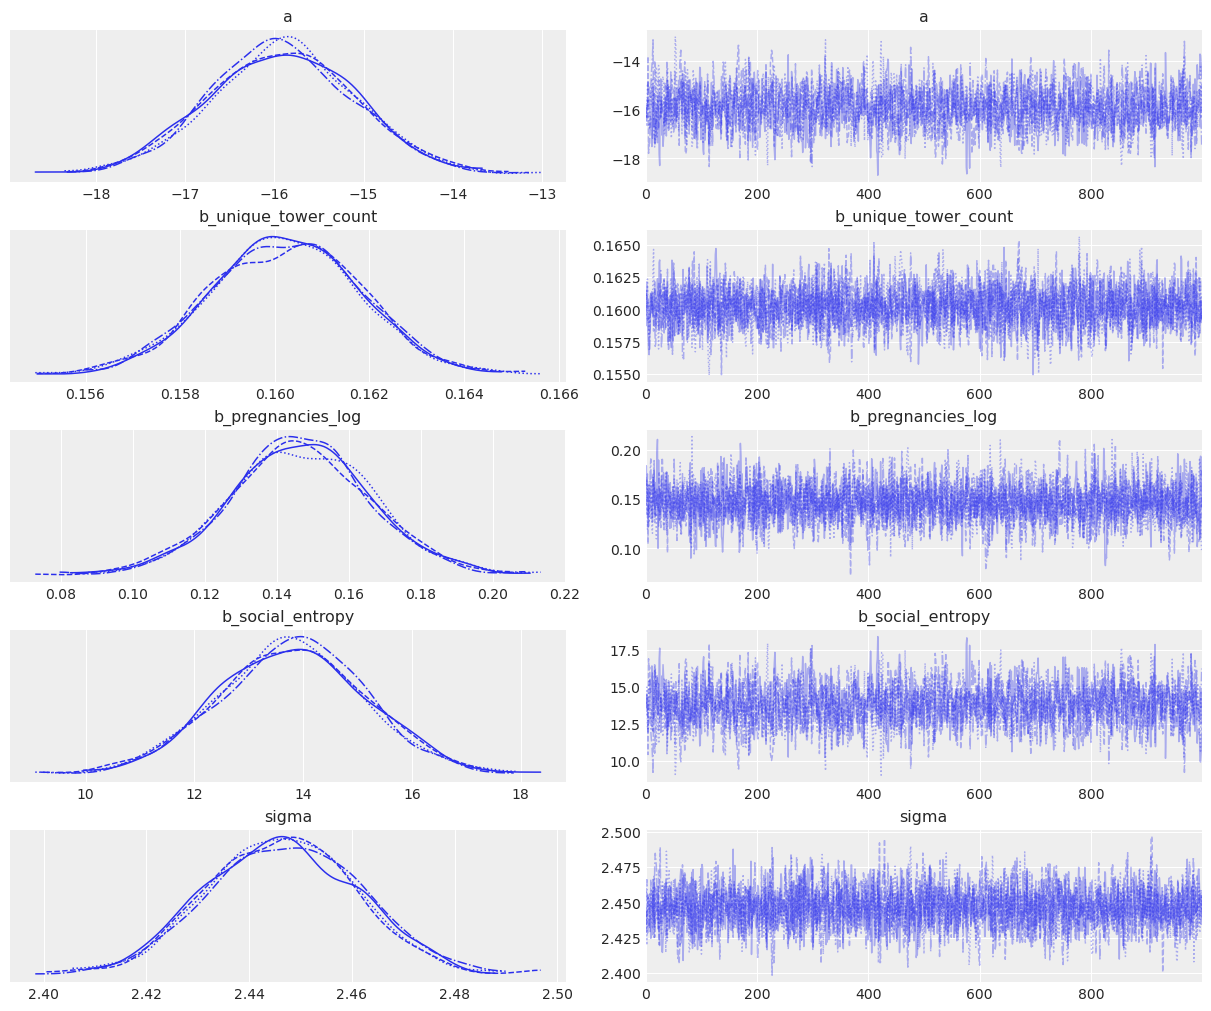

In [12]:
import pymc3 as pm
import arviz as az

with pm.Model() as model_besag_1:
    # Define the prior distributions for the parameters
    a = pm.Normal("a", mu=0, sigma=10)  # Prior for intercept
    b_unique_tower_count = pm.Normal("b_unique_tower_count", mu=0, sigma=10)  # Prior for unique_tower_count coefficient
    b_pregnancies_log = pm.Normal("b_pregnancies_log", mu=0, sigma=10)  # Prior for pregnancies_log coefficient
    b_social_entropy = pm.Normal("b_social_entropy", mu=0, sigma=10)  # Prior for social_entropy coefficient
    
    # Define the linear model
    mu = a + b_unique_tower_count * data_b['unique_tower_count'] + b_pregnancies_log * data_b['pregnancies_log'] + b_social_entropy * data_b['social_entropy']
    
    sigma = pm.Exponential("sigma", lam=1)

    # Define the likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data_b['pc_1'])

    # Run the inference with increased tuning steps
    trace = pm.sample(tune=2000, draws=1000)

    posterior_predictive = pm.sample_posterior_predictive(trace)


# Print the summary of the fitted model
print(pm.summary(trace))

# Plot the posterior distribution and prior distribution
az.plot_trace(trace)


predicted_values = posterior_predictive["y"]


In [13]:
data_b["predicted_values"] = pd.Series(predicted_values.mean(axis=0), index=data_b.index)

In [14]:
predicted_values

array([[-2.20968076,  5.04077561,  3.22652975, ...,  0.85248552,
        -3.52069784, -0.55345413],
       [ 6.27945157,  1.97222603, 10.16067185, ..., -1.94561725,
        -4.79941875, -0.76600579],
       [-2.45642912,  5.91923805,  3.35306212, ..., -4.53256878,
        -1.95943255, -4.12654885],
       ...,
       [ 3.67148187,  5.94510848,  4.65630515, ..., -2.76110164,
         3.22992473, -0.33041704],
       [ 2.69721611,  1.56674497,  4.56815982, ..., -0.99646016,
        -7.08079549, -5.88435689],
       [11.1140705 ,  1.17648246,  8.09969624, ..., -5.23284404,
        -0.06015443, -2.91847048]])

In [15]:
import os
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

In [28]:
data_shapefile = gpd.read_file("/home/manifold/Desktop/DAP/data_shapefile.shx")